In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

from statistics import mean
import random
import csv
import time

import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')
sn.set_style("whitegrid")
%matplotlib inline


from processV2 import concatenator, load_data_paths, gen_rawData
from processV2 import normaliseTestData, normaliseTrainData, plot_confusion_matrix, segment_df, getInputVector

TrainingVector shape (2698, 360)
Label Train shape (2698,)
TestingVector shape (538, 360)
Label Test shape (538,)


## Constants 

In [2]:
TRAIN_FILEPATH = "./capstone_data/train/*.csv"
TEST_FILEPATH = "./capstone_data/test/*.csv"

DANCE_TO_NUM_MAP = {'dab': 0, 'jamesbond': 1, 'mermaid': 2}
RAW_COLS = ["acc_X", "acc_Y", "acc_Z", "gyro_X", "gyro_Y", "gyro_Z","subject", "trialNum", "dance"]

DANCE_MOVES = ["jamesbond", "dab", "mermaid"]
IN_FEATURES = 360
OUT_FEATURES = 3
HIDDEN_LAYER_1_NODES = 200
HIDDEN_LAYER_2_NODES = 80
K = 10   
EPOCHS = 100
TRAIN_BATCH_SIZE = 108
TEST_BATCH_SIZE = 40
LEARNING_RATE = 0.001
NUM_TO_DANCE_MAP = {0: 'dab', 1: 'jamesbond', 2: 'mermaid'}

## Load Dataset

In [3]:
raw_train_df = concatenator(gen_rawData(load_data_paths(TRAIN_FILEPATH)))
raw_test_df = concatenator(gen_rawData(load_data_paths(TEST_FILEPATH)))
# filter_signal(raw_train_df)
# filter_signal(raw_test_df)
TRAIN_MAX = normaliseTrainData(raw_train_df)
normaliseTestData(raw_test_df, TRAIN_MAX)
raw_test_df["target"] = raw_test_df["dance"].map(DANCE_TO_NUM_MAP)
raw_train_df["target"] = raw_train_df["dance"].map(DANCE_TO_NUM_MAP)
test_segs, lbl_test = segment_df(raw_test_df, "target")
train_segs, lbl_train = segment_df(raw_train_df, "target")
training_X = getInputVector(train_segs)
testing_X = getInputVector(test_segs)
print("TrainingVector shape", training_X.shape)
print("Label Train shape", lbl_train.shape )
print("TestingVector shape", testing_X.shape)
print("Label Test shape", lbl_test.shape )

X_train = torch.FloatTensor(training_X)
X_test = torch.FloatTensor(testing_X)
y_train = torch.LongTensor(lbl_train)
y_test = torch.LongTensor(lbl_test)

TrainingVector shape (2698, 360)
Label Train shape (2698,)
TestingVector shape (538, 360)
Label Test shape (538,)


## Multi-Layer Perceptron Model

In [4]:
class Model(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

#### Instantiate Model class using default parameters

In [5]:
torch.manual_seed(32)
mlp = Model(in_features=IN_FEATURES, h1=HIDDEN_LAYER_1_NODES, h2=HIDDEN_LAYER_2_NODES, out_features=OUT_FEATURES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

#### 10-fold Stratified Cross Validation 

In [6]:
skfcv = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)
training_loss = {}
val_acc = []

# per fold 
for fold, (train_index, test_index) in enumerate(skfcv.split(X_train, y_train)):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    train_combined = TensorDataset(x_train_fold, y_train_fold)
    test_combined = TensorDataset(x_test_fold, y_test_fold)
    trainloader = DataLoader(train_combined, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    testloader = DataLoader(test_combined, batch_size=TEST_BATCH_SIZE, shuffle=False)
    # per epoch
    for i in range(EPOCHS): 
        i+=1
        # per batch 
        losses = [] 
        val_correct_preds = 0
        count = 0 
        for batch_idx, (data, target) in enumerate(trainloader):
            mlp.train()
             
            # training 
            y_pred = mlp.forward(data)
            loss = criterion(y_pred, target)
            losses.append(loss)
            
            # backtracking 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
        # validating 
        with torch.no_grad():
            mlp.eval()
            for val_batch_idx, (val_data, val_target) in enumerate(testloader):
                y_out = mlp.forward(val_data)
                for row in range(y_out.shape[0]):
                    if y_out[row].argmax() == val_target[row]:
                        val_correct_preds += 1
                    count += 1
                    
    # per fold         
    with torch.no_grad():
        training_loss[fold] = np.array(losses).mean()
        print("-----------------------")
        print(f"fold: {fold} , training_loss: {training_loss[fold]}")
        print(f"fold: {fold}, {val_correct_preds} out of {count} = {100*val_correct_preds/count:.2f}% correct")
        print("-----------------------")
        val_acc.append(100*val_correct_preds/count)
        count = 0

print()
print("Done Training")
print("Max Validation Accuracy: ",  np.array(val_acc).max())

-----------------------
fold: 0 , training_loss: 1.041891209752066e-05
fold: 0, 267 out of 270 = 98.89% correct
-----------------------
-----------------------
fold: 1 , training_loss: 6.253329956962261e-06
fold: 1, 270 out of 270 = 100.00% correct
-----------------------
-----------------------
fold: 2 , training_loss: 1.1798034620369435e-06
fold: 2, 270 out of 270 = 100.00% correct
-----------------------
-----------------------
fold: 3 , training_loss: 3.233237748645479e-07
fold: 3, 270 out of 270 = 100.00% correct
-----------------------
-----------------------
fold: 4 , training_loss: 8.468529699712235e-08
fold: 4, 270 out of 270 = 100.00% correct
-----------------------
-----------------------
fold: 5 , training_loss: 2.4530701026037605e-08
fold: 5, 270 out of 270 = 100.00% correct
-----------------------
-----------------------
fold: 6 , training_loss: 6.829467213975704e-09
fold: 6, 270 out of 270 = 100.00% correct
-----------------------
-----------------------
fold: 7 , traini

#### Mean Loss per fold 

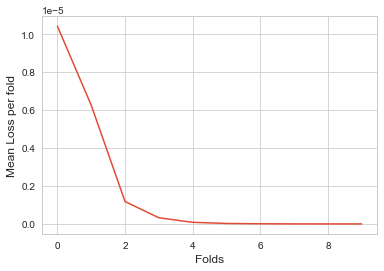

In [7]:
with torch.no_grad():
    y_axis  = training_loss.values()
    plt.plot(range(10), y_axis)
    plt.ylabel('Mean Loss per fold')
    plt.xlabel('Folds')

## Evaluation 

In [8]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    start_time = time.time()
    y_val = mlp.forward(X_test)
    print("--- %s execution time in seconds ---" % (time.time() - start_time))
    loss = criterion(y_val, y_test)
    print(f'Loss with test set : {loss:.8f}')

--- 0.02231287956237793 execution time in seconds ---
Loss with test set : 0.38664100



513 out of 538 = 95.35% correct
Confusion matrix, without normalization
tensor([[171,   9,   2],
        [  9, 171,   0],
        [  5,   0, 171]])
Classification Report for MLP :
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       182
           1       0.95      0.95      0.95       180
           2       0.99      0.97      0.98       176

    accuracy                           0.95       538
   macro avg       0.95      0.95      0.95       538
weighted avg       0.95      0.95      0.95       538



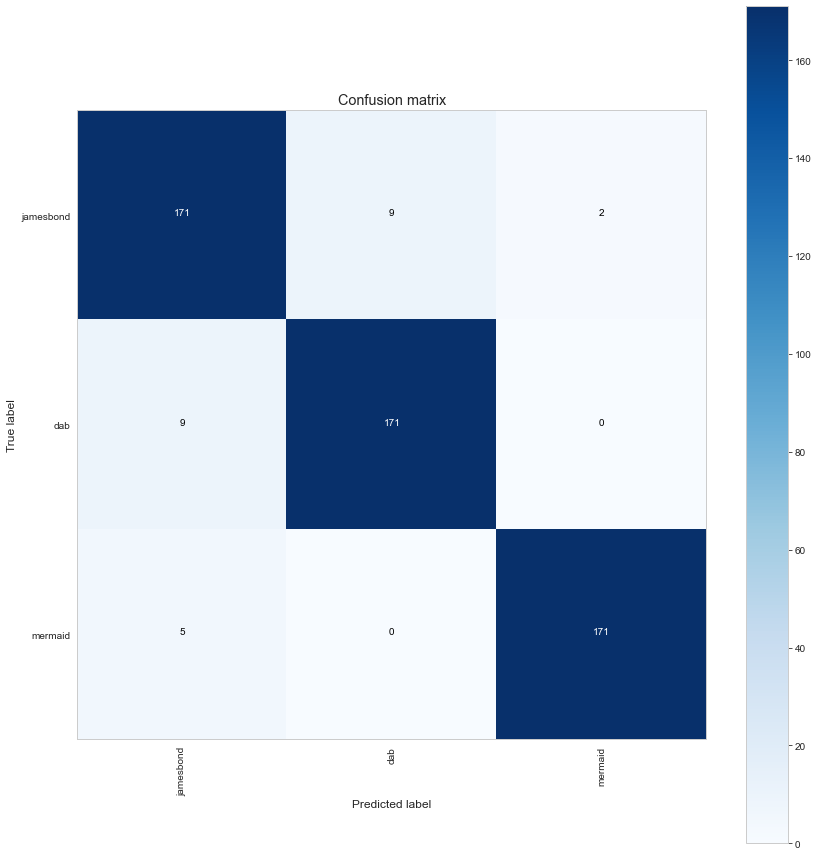

In [9]:
with torch.no_grad():
    # checking accuracy on test dataset 
    preds = []
    correct = 0
    for i,data in enumerate(X_test):
        y_val = mlp.forward(data)
        preds.append(y_val.argmax().item())
        if y_val.argmax().item() == y_test[i]:
            correct += 1
    print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
    y_preds = torch.tensor(preds, dtype = torch.int64)
    stacked = torch.stack((y_test,y_preds),dim=1)

    # confusion matrix generation 
    cmt = torch.zeros(OUT_FEATURES,OUT_FEATURES, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1  
    
    plt.figure(figsize=(12,12))
    plot_confusion_matrix(cmt, DANCE_MOVES)
    
    print("Classification Report for MLP :")
    print(classification_report(y_test, y_preds))

In [10]:
# model weights 
with torch.no_grad():
    mlp_params = {}
    for name, param in mlp.named_parameters():
        mlp_params[name] = param.numpy().copy().tolist()
        
    print(mlp_params.keys())
    for key in mlp_params.keys(): 
        print(f"{key} : {len(mlp_params[key])} neurons in {key} layer")
        print(f" number of connections  : {len(mlp_params[key])} * {np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size} = {len(mlp_params[key]) * np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size } ")

    # save model weights 
    with open('mlp.csv', 'w') as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in mlp_params.items():
           writer.writerow([key, value])

dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
fc1.weight : 200 neurons in fc1.weight layer
 number of connections  : 200 * 360 = 72000 
fc1.bias : 200 neurons in fc1.bias layer
 number of connections  : 200 * 1 = 200 
fc2.weight : 80 neurons in fc2.weight layer
 number of connections  : 80 * 200 = 16000 
fc2.bias : 80 neurons in fc2.bias layer
 number of connections  : 80 * 1 = 80 
out.weight : 3 neurons in out.weight layer
 number of connections  : 3 * 80 = 240 
out.bias : 3 neurons in out.bias layer
 number of connections  : 3 * 1 = 3 


## Save & Load Model

In [11]:
torch.save(mlp.state_dict(), 'MLPW9.pt')
loaded_model = Model(in_features=IN_FEATURES,h1=HIDDEN_LAYER_1_NODES, h2=HIDDEN_LAYER_2_NODES, out_features=OUT_FEATURES) 
loaded_model.load_state_dict(torch.load('MLPW9.pt'))
loaded_model.eval()

Model(
  (fc1): Linear(in_features=360, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (out): Linear(in_features=80, out_features=3, bias=True)
)

In [12]:
# loss when loaded model is run on test dataset 
with torch.no_grad():
    y_val = loaded_model.forward(X_test)
    loss = criterion(y_val, y_test)
    print(f'{loss:.8f}')

0.38664100


In [13]:
# run model on a random sample row of the test dataset 
random.seed(69)
random_int = random.randint(0, len(testing_X))
random_input = torch.FloatTensor(testing_X[random_int])
print(random_input)

with torch.no_grad():
    print(loaded_model(random_input))
    print()
    print(loaded_model(random_input).max())
    print(loaded_model(random_input).argmax().item())
    print(f"Predicted Output: {NUM_TO_DANCE_MAP[loaded_model(random_input).argmax().item()]}")
    print(f"Actual Output: {NUM_TO_DANCE_MAP[y_test[random_int].item()]}")

tensor([-3.7010e-01, -2.6770e-01, -1.9690e-01, -1.8110e-01, -1.4170e-01,
        -1.1020e-01, -7.9000e-03,  1.1020e-01,  2.4410e-01,  2.4410e-01,
         2.3620e-01,  8.6600e-02, -3.9400e-02, -3.4650e-01, -5.9060e-01,
        -7.0870e-01, -9.2130e-01, -9.4490e-01, -9.4490e-01, -7.9530e-01,
        -7.5590e-01, -5.1180e-01, -3.3860e-01, -2.7560e-01, -2.0470e-01,
        -1.1020e-01, -1.0240e-01,  3.9400e-02,  1.0240e-01,  2.9920e-01,
         2.9920e-01,  1.3390e-01, -1.5700e-02, -3.7800e-01, -6.4570e-01,
        -6.7720e-01, -8.1100e-01, -9.0550e-01, -8.1100e-01, -7.5590e-01,
        -2.5980e-01, -4.1730e-01, -4.7240e-01, -6.2200e-01, -6.2200e-01,
         5.6690e-01,  5.6690e-01,  3.0710e-01,  7.8700e-02, -1.1810e-01,
        -1.1810e-01, -1.0240e-01,  6.3000e-02,  1.8900e-01,  3.4650e-01,
         4.6460e-01,  5.1970e-01,  5.3540e-01,  5.3540e-01, -5.2760e-01,
        -5.4330e-01, -5.4330e-01, -6.2200e-01, -7.0080e-01, -7.0080e-01,
         5.1970e-01,  5.1970e-01,  3.0710e-01,  1.4

In [14]:
# save test dataset
with torch.no_grad(): 
    x = X_test.numpy().copy().tolist()
    np.savetxt("X_test.csv", x, delimiter=",")
    y = y_test.numpy().copy().tolist()
    np.savetxt("y_test.csv", y, delimiter=",")

In [15]:
TRAIN_MAX

{'acc_X': 1.27,
 'acc_Y': 1.27,
 'acc_Z': 1.27,
 'gyro_X': 276.28,
 'gyro_Y': 266.44,
 'gyro_Z': 271.8,
 'yaw': 327.28,
 'pitch': 15.59,
 'roll': 15.14}